<a href="https://colab.research.google.com/github/Ilvecho/Project_2/blob/main/P3_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install thefuzz[speedup]

In [5]:
import numpy as np
import pandas as pd
import re
from thefuzz import fuzz
from thefuzz import process
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots

from google.colab import files
files.upload()
pass

Saving potential-talents - Aspiring human resources - seeking human resources.csv to potential-talents - Aspiring human resources - seeking human resources.csv


In [6]:
raw_data = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

# Preliminary data analysis

In [3]:
raw_data.head()

id                                          job_title  \
0   1  2019 C.T. Bauer College of Business Graduate (...   
1   2  Native English Teacher at EPIK (English Progra...   
2   3              Aspiring Human Resources Professional   
3   4             People Development Coordinator at Ryan   
4   5    Advisory Board Member at Celal Bayar University   

                              location connection  fit  
0                       Houston, Texas         85  NaN  
1                               Kanada      500+   NaN  
2  Raleigh-Durham, North Carolina Area         44  NaN  
3                        Denton, Texas      500+   NaN  
4                       İzmir, Türkiye      500+   NaN

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [6]:
print(raw_data.isnull().sum())

id              0
job_title       0
location        0
connection      0
fit           104
dtype: int64


In [4]:
duplicate_rows = raw_data.duplicated(subset=['job_title', 'location', 'connection'])
print(duplicate_rows.sum())

51


there are 51 rows that are duplicates of already existing rows.
Note that to identify the duplicates we excluded the column 'id' as those are unique.

Ultimately, we need to understand whether these duplicate rows are actually duplicates, or simply represent different individuals with the same job title and number of connections.

I think that they are duplicate, as we detected rows with **excacly** the same job title and numebr of connections

In [5]:
# convert the column connection from object to int
raw_data = raw_data.mask(raw_data == '500+ ', other=501)
raw_data.connection = pd.to_numeric(raw_data.connection)

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    int64  
 4   fit         0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.2+ KB


Let's look at the data distribution for each feature

In [ ]:
# let's start from the connection feature as it is the easiest to verify
raw_data.connection.value_counts()

In [6]:
unique_data = raw_data[~duplicate_rows.values]
unique_data = unique_data.reset_index().drop('index', axis=1)

In [53]:
unique_data.shape

(53, 5)

In [ ]:
job_title_similarity = np.zeros((unique_data.shape[0], unique_data.shape[0]))
location_similarity = np.zeros((unique_data.shape[0], unique_data.shape[0]))

In [ ]:
for index, row in unique_data.iterrows():
  # compute the similarity for Job Title
  tmp = process.extract(row.job_title, unique_data.job_title, limit=60, scorer=fuzz.partial_token_set_ratio)
  for i in np.arange(len(tmp)):
    _, score, idx = tmp[i]
    job_title_similarity[index][idx] = score

  # compute the similarity for Location
  tmp = process.extract(row.location, unique_data.location, limit=60, scorer=fuzz.partial_token_set_ratio)
  for i in np.arange(len(tmp)):
    _, score, idx = tmp[i]
    location_similarity[index][idx] = score

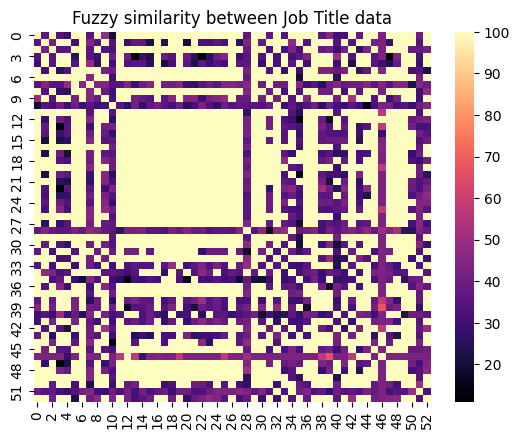

In [75]:
# plot the two results as heatmap
ax= plt.subplot()
sns.heatmap(job_title_similarity, cmap='magma', fmt='g', ax=ax);
ax.set_title('Fuzzy similarity between Job Title data');
plt.show()

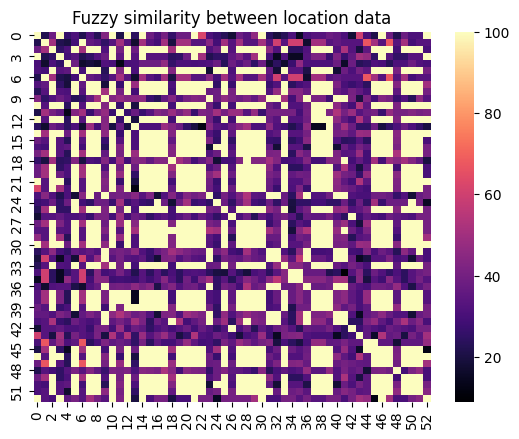

In [77]:
ax= plt.subplot()
sns.heatmap(location_similarity, cmap='magma', fmt='g', ax=ax);
ax.set_title('Fuzzy similarity between location data');
plt.show()

In [78]:
process.extract("seeking human resources", unique_data.job_title, limit=3, scorer=fuzz.partial_token_set_ratio)

[('2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional',
  100,
  0),
 ('Aspiring Human Resources Professional', 100, 2),
 ('Aspiring Human Resources Specialist', 100, 5)]

In [80]:
unique_data.location.value_counts()

Houston, Texas Area                    4
Raleigh-Durham, North Carolina Area    3
Greater New York City Area             3
Austin, Texas Area                     2
Amerika Birleşik Devletleri            2
Kanada                                 2
Greater Philadelphia Area              2
Greater Atlanta Area                   2
Torrance, California                   1
Highland, California                   1
Gaithersburg, Maryland                 1
Baltimore, Maryland                    1
Milpitas, California                   1
Greater Chicago Area                   1
Houston, Texas                         1
Long Beach, California                 1
Chattanooga, Tennessee Area            1
Bridgewater, Massachusetts             1
Lafayette, Indiana                     1
Kokomo, Indiana Area                   1
Las Vegas, Nevada Area                 1
Cape Girardeau, Missouri               1
Greater Los Angeles Area               1
Los Angeles, California                1
Dallas/Fort Wort

# Pre processing - Location

First thing we convert the feature contact to int

In [7]:
# convert the column connection from object to int
raw_data = raw_data.mask(raw_data == '500+ ', other=501)
raw_data.connection = pd.to_numeric(raw_data.connection)

Then, we remove the duplicates

In [8]:
duplicate_rows = raw_data.duplicated(subset=['job_title', 'location', 'connection'])
unique_data = raw_data[~duplicate_rows.values]
unique_data = unique_data.reset_index().drop('index', axis=1)

Pre-processing of the column location:

The goal is to obtain either a country, or CITY, STATE for US cities

- Remove the word 'Area'
- Remove the word 'Greater'
- Substitute 'Kanada' with 'Canada'

In [9]:
unique_data.location = unique_data.location.str.replace(' Area', '')
unique_data.location = unique_data.location.str.replace('Greater ', '')
unique_data.location = unique_data.location.str.replace('Kanada', 'Canada')

Now we need to identify different forms to indicate the same city: to do so we are going to use fuzzy matching

In [10]:
replacements = {}

for location in unique_data.location.unique():
  # compute the similarity for Job Title
  tmp = process.extract(location, unique_data.location.unique(), limit=3, scorer=fuzz.token_set_ratio)
  for i in np.arange(len(tmp)):
    # we have a match but the strings are not identical
    if tmp[i][1] > 90 and location != tmp[i][0]:
      # then, we replace the string WITHOUT comma (City name only) with the string WITH the comma (City, State)
      if ',' in location:
        replacements[tmp[i][0]] = location
      elif ',' in tmp[i][0]:
        replacements[location] = tmp[i][0]

for key in replacements.keys():
  unique_data.location = unique_data.location.mask(unique_data.location == key, other=replacements[key])

In [11]:
# Manual touch to accomodate my tastes
unique_data.location = unique_data.location.str.replace('York,', 'York City,')

In [12]:
# let's now check the strings that still don't contain a comma
for location in unique_data.location.value_counts().keys():
  if ',' not in location:
    print(location)

Amerika Birleşik Devletleri
Canada
Philadelphia
Dallas/Fort Worth
Boston
San Francisco Bay


In [13]:
# Manually fix this last surviving examples
unique_data.location = unique_data.location.str.replace('Philadelphia', 'Philadelphia, Pennsylvania')
unique_data.location = unique_data.location.str.replace('Dallas/Fort Worth', 'Dallas, Texas')
unique_data.location = unique_data.location.str.replace('Boston', 'Boston, massachusetts')
unique_data.location = unique_data.location.str.replace('San Francisco Bay', 'San Francisco, California')

# Amerika Birleşik Devletleri in turkish means United States of America
unique_data.location = unique_data.location.str.replace('Amerika Birleşik Devletleri', 'United States')

In [14]:
# Now that we have (almost) all the locations as city, state
# we split them
city_list = []
state_list = []


for index, row in unique_data.iterrows():
  # compute the similarity for Job Title
  if ',' not in row.location:
    city_list.append('')
    state_list.append(row.location)
  else:
    city, state = row.location.split(', ')
    city_list.append(city)
    state_list.append(state)

In [15]:
unique_data['city'] = city_list
unique_data['state'] = state_list

In [16]:
px.bar(x=unique_data.location.value_counts().keys(), y=unique_data.location.value_counts(), title='Location bar plot')

In [127]:
px.bar(x=unique_data.city.value_counts().keys(), y=unique_data.city.value_counts(), title='City bar plot')

In [17]:
px.bar(x=unique_data.state.value_counts().keys(), y=unique_data.state.value_counts(), title='State bar plot')

# Pre processing - Job Title

In [31]:
# store a copy to do different testing
unique_data_copy = unique_data.copy()

Remove digits and special characters

In [135]:
unique_data = unique_data_copy.copy()

In [126]:
unique_data['no_symbols'] = unique_data['job_title'].apply(lambda x: re.sub('[^a-z ]', ' ', x.lower()))
unique_data['no_symbols'] = unique_data['no_symbols'].apply(lambda x: re.sub(' [ ]*', ' ', x))

Remove stopwords

In [127]:
stop = stopwords.words('english')

unique_data['no_stopwords'] = unique_data['no_symbols'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Substitute Acronyms and abbreviations

We identified words with 4 characters or less and manually decided how to deal with them:

- Problematic word: ('c', 'JJ'): already removed in the lemmazation step
- Problematic word: ('cum', 'NN'): remove, it a stop word ('cum' in latin is 'with')
- Problematic word: ('epik', 'JJ'): remove, the acronym is already expanded
- Problematic word: ('ryan', 'NN'): ignore, name of a company
- Problematic word: ('hr', 'NN'): expand in 'human resource'
- Problematic word: ('hris', 'VBP'): expand in 'human resource information system'
- Problematic word: ('svp', 'NN'): expand in 'senior vice president'
- Problematic word: ('chro', 'NN'): expand in 'chief human resource officer'
- Problematic word: ('csr', 'VBP'): expand in 'corporate social responsibility'
- Problematic word: ('gphr', 'NN'): expand in 'global professional in human resources'
- Problematic word: ('sphr', 'NN'):  expand in 'senior professional in human resources'
- Problematic word: ('army', 'JJ'): ignore
- Problematic word: ('inc', 'NN'): remove
- Problematic word: ('work', 'NN'): ignore
- Problematic word: ('arts', 'NNS'): ignore
- Problematic word: ('mes', 'NNS'): expand in 'manufacturing execution system'
- Problematic word: ('heil', 'NN'): ignore, company name
- Problematic word: ('team', 'NN'): ignore
- Problematic word: ('gis', 'NN'): expand in 'geographic information system'
- Problematic word: ('rrp', 'NN'): expand in 'recommended retail price'
- Problematic word: ('jti', 'NN'): remove, already expanded
- Problematic word: ('love', 'NN'): ignore
- Problematic word: ('data', 'NNS'): ignore
- Problematic word: ('ey', 'VBP'): ignore, name of the company
- Problematic word: ('lab', 'NN'): ignore
- Problematic word: ('lead', 'JJ'): ignore
- Problematic word: ('care', 'NN'): ignore
- Problematic word: ('long', 'RB'): ignore
- Problematic word: ('open', 'VBP'): ignore
- Problematic word: ('may', 'MD'): this is actually removed by the lemmization
- Problematic word: ('st', 'NN'): expand in 'saint'
- Problematic word: ('set', 'VBN'): ignore

In [128]:
to_remove = {'cum', 'epik', 'inc', 'jti'}
to_replace = {
    'hr': 'human resources',
    'hris': 'human resources information system',
    'svp': 'senior vice president',
    'chro': 'chief human resources officer',
    'csr': 'corporate social responsibility',
    'gphr': 'global professional human resources',
    'sphr': 'senior professional human resources',
    'mes': 'manufacturing execution system',
    'gis': 'geographic information system',
    'rrp': 'recommended retail price',
    'st': 'saint'
}

modified_no_stopwords = []

for _, row in unique_data.iterrows():
  # store the extracted string
  temp_string = row.no_stopwords
  for word in row.no_stopwords.split():
    # if a word is to remove, replace it with empty
    if word in to_remove:
      temp_string = row.no_stopwords.replace(word, '')
    # if a word is to replace, substitute it with the replacement
    elif word in to_replace.keys():
      temp_string = row.no_stopwords.replace(word, to_replace[word])
    # modify the row -> it might be that several acronyms are in the same row, so we need to store it for the next word iteration, otherwise we are going to lose the modifications
    row.no_stopwords = temp_string

  # create a list to modify the dataframe
  modified_no_stopwords.append(row.no_stopwords)

unique_data['no_stopwords'] = modified_no_stopwords

Tokenize and compute the POS tags

In [130]:
unique_data['jt_tokenized'] = unique_data['no_stopwords'].apply(lambda x: word_tokenize(x))
unique_data['jt_pos_tag'] = unique_data['jt_tokenized'].apply(lambda x: pos_tag(x))

Find the lemma of each token, then reconstruct the sentence with the lemmas

In [131]:
wnl = WordNetLemmatizer()
job_title_lemma = []

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

for index, row in unique_data.iterrows():
  row_lemma = []
  for word in row.jt_pos_tag:
    pos = get_wordnet_pos(word[1])
    if len(word[0]) <2 or pos == '':
      print(word)
      continue
    row_lemma.append(wnl.lemmatize(word[0], pos=pos))
  job_title_lemma.append(row_lemma)


unique_data['jt_lemma'] = job_title_lemma
unique_data['jt_lemma'] = unique_data['jt_lemma'].apply(lambda x: ' '.join(word for word in x))

('c', 'JJ')
('within', 'IN')
('may', 'MD')


# Pre processing - search key words

We want to put the search keywords in the same condition as the job title:
- lower chars
- no stopwords
- lemmas

In [146]:
search_keywords = ['aspiring human resources', 'seeking human resources']
temp_pos_tag = []
sk_pos_tag = []
sk_lemma = []

for sentence in search_keywords:
  sk_pos_tag.append(pos_tag(sentence.split()))

for sentence in sk_pos_tag:
  sk_words_lemma = []
  for word in sentence:
    pos = get_wordnet_pos(word[1])
    sk_words_lemma.append(wnl.lemmatize(word[0], pos=pos))
  sk_lemma.append( ' '.join(word for word in sk_words_lemma))

print(sk_lemma)

['aspire human resource', 'seek human resource']
